<a href="https://colab.research.google.com/github/Gregtom3/vossen_ecal_ai/blob/main/notebooks/nb05_ecal_condensation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gregory Matousek

Contact: gregory.matousek@duke.edu

# Tutorial Overview

In this notebook we generate pseudodata of electromagnetic calorimeter hits at CLAS12. We develop a neural network based on GravNet that learns to map each calorimeter hit to a latent space where clustering can be performed. The neural network is trained to minimize the object condensation loss to produce this minimization.

# Imports

In [20]:
# Import source code from the GitHub to generate ECal hits
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/ecal_gen.py
from ecal_gen import ECALDataset

# Import csv table from the GitHub storing ECal hits
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/ecal_hits_table.csv

# Import source code from the GitHub for the object condensation loss function
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/nb03_loss_functions.py
from nb03_loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric, condensation_loss

# Import source code for GravNet layers
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/gravnet/Layers.py
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/gravnet/caloGraphNN.py
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/gravnet/caloGraphNN_keras.py
from Layers import GravNet

--2025-03-13 21:48:22--  https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/ecal_gen.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14990 (15K) [text/plain]
Saving to: ‘ecal_gen.py.3’

ecal_gen.py.3       100%[===================>]  14.64K  --.-KB/s    in 0.001s  

2025-03-13 21:48:22 (10.5 MB/s) - ‘ecal_gen.py.3’ saved [14990/14990]

--2025-03-13 21:48:22--  https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/ecal_hits_table.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300591 (294K) [text

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Data Generation

## Creating the data

From the GitHub, the source code `src/ecal_gen.py` handles the generation of fake ECal hits at CLAS12. The geometry of the ECal is identical, though. There are 2448 different strips at CLAS12, split amongst the six azimuthal sectors. The precise $(x,y,z)$ for each strip is stored in a data table at `src/ecal_hits_table.csv`.

In the simulation, we only produce hits in the PCal, as opposed to propagating them through the ECin and ECout. This is done as a simplification.

Below, we generate these fake hits with a basic seeding algorithm.

In [3]:
# Maximum number of hits per event
K=150
events = 1000
dataset = ECALDataset(N=events,                  # Number of events
                      variance=10,               # Increase to cause more adjacent strips to flash
                      min_particles=3,           # Minimum number of particles per event
                      max_particles=3,           # Maximum number of particles per event
                      K=150,
                      random_sector=True,        # True: Particles are generated randomly in each sector
                                                 # False: Particles are generated in a single sector (sector 1)
                      force_same_sector=False    # True: At least two different particles hit the same sector
                                                 # False: Any number of particles can hit the same sector
                    )

# Obtain strip data from `ECALDataset`
strip_X, strip_y = dataset.get_data()

print("\nstrip_X.shape", strip_X.shape)
print("strip_y.shape", strip_y.shape)

# strip_X --> [N,K,8]
#  0: x1 - x coordinate of strip endpoint 1
#  1: y1 - y coordinate of strip endpoint 1
#  2: z1 - z coordinate of strip endpoint 1
#  3: x2 - x coordinate of strip endpoint 2
#  4: y2 - y coordinate of strip endpoint 2
#  5: z2 - z coordinate of strip endpoint 2
#  6: component: Labels strip within layer
#  7: layer: Labels layer of hit

# strip_y --> [N,K,1]
#  0: Unique particle id of strip
#     Strips that share particle id come from the same Monte Carlo 'particle'

  2%|▏         | 24/1000 [00:01<01:21, 11.95it/s]

Layer 3 fail for sector 4 in event 21
Retrying event 21


  6%|▋         | 64/1000 [00:04<01:20, 11.56it/s]

Layer 3 fail for sector 3 in event 60
Retrying event 60


 14%|█▍        | 145/1000 [00:11<03:03,  4.67it/s]

Layer 3 fail for sector 4 in event 143
Retrying event 143


 19%|█▉        | 190/1000 [00:15<01:06, 12.27it/s]

Layer 3 fail for sector 1 in event 186
Retrying event 186


 24%|██▍       | 240/1000 [00:18<01:05, 11.59it/s]

Layer 3 fail for sector 5 in event 237
Retrying event 237


 25%|██▌       | 252/1000 [00:19<01:28,  8.47it/s]

Layer 3 fail for sector 3 in event 250
Retrying event 250


 26%|██▌       | 259/1000 [00:20<01:34,  7.88it/s]

Layer 3 fail for sector 1 in event 258
Retrying event 258


 34%|███▎      | 336/1000 [00:26<01:04, 10.27it/s]

Layer 3 fail for sector 1 in event 335
Retrying event 335


 34%|███▍      | 340/1000 [00:27<01:14,  8.87it/s]

Layer 3 fail for sector 6 in event 337
Retrying event 337


 34%|███▍      | 344/1000 [00:27<01:16,  8.53it/s]

Layer 3 fail for sector 3 in event 341
Retrying event 341


 35%|███▍      | 346/1000 [00:28<01:37,  6.72it/s]

Layer 3 fail for sector 1 in event 344
Retrying event 344


 43%|████▎     | 426/1000 [00:34<01:01,  9.36it/s]

Layer 3 fail for sector 6 in event 424
Retrying event 424


 44%|████▍     | 443/1000 [00:35<01:16,  7.28it/s]

Layer 3 fail for sector 3 in event 441
Retrying event 441


 49%|████▉     | 494/1000 [00:39<00:51,  9.87it/s]

Layer 3 fail for sector 6 in event 493
Retrying event 493


 65%|██████▍   | 648/1000 [00:50<00:30, 11.54it/s]

Layer 3 fail for sector 1 in event 645
Retrying event 645


 71%|███████   | 711/1000 [00:55<00:33,  8.60it/s]

Layer 3 fail for sector 1 in event 709
Retrying event 709


 72%|███████▏  | 717/1000 [00:55<00:31,  8.92it/s]

Layer 3 fail for sector 5 in event 714
Retrying event 714


 73%|███████▎  | 729/1000 [00:56<00:24, 11.24it/s]

Layer 3 fail for sector 6 in event 726
Retrying event 726


 76%|███████▌  | 756/1000 [00:59<00:23, 10.50it/s]

Layer 3 fail for sector 4 in event 756
Retrying event 756


 78%|███████▊  | 778/1000 [01:02<00:36,  6.06it/s]

Layer 3 fail for sector 3 in event 776
Retrying event 776


 79%|███████▉  | 794/1000 [01:04<00:22,  9.29it/s]

Layer 3 fail for sector 1 in event 792
Retrying event 792


 82%|████████▏ | 820/1000 [01:06<00:19,  9.10it/s]

Layer 3 fail for sector 3 in event 816
Retrying event 816


 84%|████████▍ | 838/1000 [01:08<00:16,  9.67it/s]

Layer 3 fail for sector 6 in event 835
Retrying event 835


 84%|████████▍ | 844/1000 [01:09<00:22,  6.91it/s]

Layer 3 fail for sector 2 in event 843
Retrying event 843


 90%|████████▉ | 897/1000 [01:13<00:13,  7.72it/s]

Layer 3 fail for sector 4 in event 896
Retrying event 896


 91%|█████████ | 911/1000 [01:15<00:13,  6.38it/s]

Layer 3 fail for sector 4 in event 909
Retrying event 909


 97%|█████████▋| 971/1000 [01:20<00:02, 11.70it/s]

Layer 3 fail for sector 3 in event 968
Retrying event 968


100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


strip_X.shape (1000, 150, 8)
strip_y.shape (1000, 150, 1)


## Data Visualization (Event Plot)

In the code below we generate a 2D plot of the ECal strips hit for a given event. This $(x,y)$ plot helps use visualize how the CLAS12 ECal records data. The lines represent strips, and the marker colors attached to the ends of the lines mark the particle that *caused* the hit.
- When we say *cause* we imply primary, secondary, etc. hits. When a particle enters the CLAS12 calorimeter, it interacts with the lead sheets, generating secondary particles. These secondary particles pass through the lead and are measured by the scintallating strips (shown in the plot). In Geant4 we are able to trace back the final state particle responsible for each scintillator strip hit. Of course here we are merely creating pseudodata.

Using the 3-way intersection of hit strips, one can infer *where* a particle entered the calorimeter. For particles like photons and neutrons, this information is crucial because otherwise we have no other useful information for determining their 3-momentum.

In [8]:
def plot_event_strips(strip_X, strip_y, event=0):
    """
    Plot ECAL strips for a given event with a hexagonal grid centered at (0.5, 0.5).

    Parameters:
        strip_X (np.ndarray): Array with shape [N, K, 8] containing strip endpoints and info.
                              Columns 0,1 are x1,y1 and 3,4 are x2,y2.
        strip_y (np.ndarray): Array with shape [N, K, 1] containing particle IDs (<=0 are background).
        event (int): Index of the event to plot.
    """
    # Extract data for the selected event
    X_event_all = strip_X[event]          # shape: [K, 8]
    y_event_all = strip_y[event].squeeze()  # shape: [K,]

    # Filter out background strips (particle id <= 0)
    mask = y_event_all > 0
    X_event = X_event_all[mask]
    y_event = y_event_all[mask]

    # Assign colors based on unique particle IDs using the "Set1" colormap.
    unique_ids = np.unique(y_event)
    cmap = plt.get_cmap("Set1", 10)
    id_to_color = {pid: cmap(i) for i, pid in enumerate(unique_ids)}

    # Create the plot
    plt.figure(figsize=(5, 5), dpi=150)
    for strip, pid in zip(X_event, y_event):
        # Extract endpoints: x1, y1 (columns 0,1) and x2, y2 (columns 3,4)
        x1, y1, _, x2, y2, _, _, layer = strip
        color = id_to_color[pid]

        # Plot a line connecting the two endpoints in black (with transparency)
        plt.plot([x1, x2], [y1, y2], color='black', linewidth=1, alpha=0.3)
        # Plot markers at the endpoints with the particle's color and a black edgecolor
        plt.plot(x1, y1, marker='o', markersize=8, markerfacecolor=color, markeredgecolor='black', alpha=0.75)
        plt.plot(x2, y2, marker='o', markersize=8, markerfacecolor=color, markeredgecolor='black', alpha=0.75)

    # Draw dotted lines dividing the plot into 6 sectors.
    ax = plt.gca()
    # Use (0.5, 0.5) as the center of the hexagonal grid
    center = (0.5, 0.5)
    # Determine a radius that extends beyond the current plot limits relative to the center.
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    r = max(abs(xlim[0] - center[0]), abs(xlim[1] - center[0]),
            abs(ylim[0] - center[1]), abs(ylim[1] - center[1])) * 5

    # Define 6 evenly spaced angles (in degrees), starting with vertical (90°)
    angles_deg = [90 + i * 60 for i in range(6)]
    for angle in angles_deg:
        angle_rad = np.deg2rad(angle)
        x_end = center[0] + r * np.cos(angle_rad)
        y_end = center[1] + r * np.sin(angle_rad)
        plt.plot([center[0], x_end], [center[1], y_end], linestyle=':', color='gray')

    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.title(f"ECAL Strips Plot for Event {event}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

num_events = strip_X.shape[0]

# Create an interactive slider for events.
interact(lambda event: plot_event_strips(strip_X, strip_y, event),
         event=widgets.IntSlider(min=0, max=num_events-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='event', max=999), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>(event)>

## Histograms of Features

We can produce a grid of histograms showing the strip features of all generated events.

In the case that events do not have `K` or more strips hit, the remaining strips are considered background. A checkbox can turn on and off this background contribution.

You may be alarmed that there is a significant spike in $z_2$ for non-background hits. I double-checked, and it does seem that a large number of strips at CLAS12, at least in the PCal, have nearly the same $z$ endpoint. This makes sense if we think about how the geometry of the calorimeter should be align at a particular $z$. This value happens to be around $610cm$ from the target.

The 3 spikes in non-background hit layer number correspond to the U, V, and W layers of the ECal. These are oriented 120 degrees relative to one another to create the 3-way intersection.

In [7]:

def plot_strip_feature_histograms(strip_X, strip_y, filter_background=True):
    """
    Produce a grid of histograms showing the distributions of each strip feature over all events.

    Parameters:
        strip_X (np.ndarray): Array with shape [N, K, 8] containing strip endpoints and info.
                              Features: [x1, y1, z1, x2, y2, z2, component]
        strip_y (np.ndarray): Array with shape [N, K, 1] containing particle IDs.
        filter_background (bool): If True, only include hits with strip_y > 0.
    """
    # If filtering background, apply mask (strip_y <= 0 are excluded)
    if filter_background:
        mask = strip_y.squeeze() > 0
        data = strip_X[mask]
    else:
        data = strip_X.reshape(-1, 8)

    # Define feature names
    feature_names = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'component', 'layer']

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Loop over each feature and plot its histogram
    for i in range(8):
        ax = axes[i]
        ax.hist(data[:, i], bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f"Histogram of {feature_names[i]}")
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel("Count")


    plt.tight_layout()
    plt.show()

# Create an interactive widget
interact(lambda filter_background: plot_strip_feature_histograms(strip_X, strip_y, filter_background),
         filter_background=widgets.Checkbox(value=True, description="Filter background hits (strip_y > 0)"))

interactive(children=(Checkbox(value=True, description='Filter background hits (strip_y > 0)'), Output()), _do…

<function __main__.<lambda>(filter_background)>

# Creating the Model

The neural network architecture we will be building uses GravNet layers. They were first introduced in the following paper https://arxiv.org/abs/1902.07987 and have been used by several other detector AI studies.

![GravNet](https://github.com/Gregtom3/vossen_ecal_ai/blob/main/docs/gravnet.png?raw=true)

In a typical GNN, the user defines which vertices are connected with edges and thus *pass information* between one another. For example, `kNN` or `k-nearest-neighbor` architectures define connectivities based on some number of nearest neighbors, where *nearest* could be determined with some euclidean distance of the node features. In contrast, GravNet dynamically learns its own connections by mapping each point to a location in a latent space.

Here is a brief summary from my paper

>In each GravNet layer, every node is mapped to a latent $S$-space where it learns intrinsic features. Each node's
$S$-space representation is then refined by aggregating information from its $k$-nearest neighbors using distance-weighted mean and max functions, and these aggregated features, along with the node's original and $S$-space features, are updated via a fully-connected MLP.

GravNet works very well for irregular detector geometries. This is because we do not have to concern ourselves with feeding the model information of how it should *think* two nodes are connected to one another - it learns this dynamically during training. In the case of our ECal geometry, two hits that intersect in $(x,y)$ space *should* be "talking" to one another. Rather than define connectivity ourselves, GravNet does it for us.

The input to the full network is $x\in[B,K,6]$ where $B$ is the `batch_size`. The first step is to pass the input through $N=2$ (by default) GravNet blocks.

**GravNet Block**: For each block, an MLP expands the feature size to $out\in[B,K,Dense1\_output]$. This is fed into a GravNet layer which produces an output $out\in[B,K,n_{filters}]$. This is finally passed through one more MLP to yield $out\in[B,K,Dense2\_output]$.

The output of each consecutive GravNet block is passed into the next. The output of all GravNet blocks and the original input is concatenated together and passed through two final MLPs, at which point an MLP head for predicting $\beta$ (object condensation variable) and $(x_c,y_c)$ is run. The output of the full network is $[B,K,3]$ where $0\rightarrow\beta$, $1\rightarrow x_c$ and $2\rightarrow y_c$.




In [26]:
def make_gravnet_model(
    K=150,
    N_grav_layers=2,
    N_neighbors=10,
    gravnet_params={
        "n_dimensions": 4,
        "n_propagate": 32,
        "n_filters": 64,
    },
    dense_params={
        "Dense1_output": 64,
        "Dense1_activation": "elu",
        "Dense2_output": 32,
        "Dense2_activation": "elu",
    },
    final_dense_params=[
        {"units": 64, "activation": "linear"},
        {"units": 32, "activation": "linear"},
    ]
):
    """
    Creates a GravNet-based model with parameterized configurations

    Parameters:
        K (int): Number of objects (e.g., particles).
        N_grav_layers (int): Number of GravNet layers.
        N_neighbors (int or list): Number of neighbors for each GravNet layer.
        gravnet_params (dict): Parameters for GravNet layers.
        dense_params (dict): Parameters for Dense layers before/after GravNet.
        final_dense_params (list): List of dictionaries for final Dense layers.
    """

    # Ensure N_neighbors is a list of the correct length
    if isinstance(N_neighbors, int):
        N_neighbors = [N_neighbors] * N_grav_layers
    else:
        assert (
            len(N_neighbors) == N_grav_layers
        ), "N_neighbors must have the same length as N_grav_layers."

    inputs = Input(shape=(K, 6), name="input_all_features")

    x = inputs
    # -------------------------------------------------------------------------
    # GravNet + Dense Layers
    # -------------------------------------------------------------------------
    feat = []
    for i in range(N_grav_layers):
        # First Dense layer before GravNet
        x = Dense(
            dense_params["Dense1_output"],
            activation=dense_params["Dense1_activation"],
            name=f"Dense1_l{i}",
        )(x)

        # GravNet layer
        x = GravNet(
            n_neighbours=N_neighbors[i],
            n_dimensions=gravnet_params["n_dimensions"],
            n_filters=gravnet_params["n_filters"],
            n_propagate=gravnet_params["n_propagate"],
            subname=f"GNet_l{i}",
            name=f"GNet_l{i}",
        )(x)

        # Second Dense layer after GravNet
        feat_layer = Dense(
            dense_params["Dense2_output"],
            activation=dense_params["Dense2_activation"],
            name=f"Dense2_l{i}",
        )(x)

        feat.append(feat_layer)

    # Concatenate features from all GravNet layers
    x = Concatenate(name="concat1")(feat)

    # Final dense layers
    for idx, layer_params in enumerate(final_dense_params):
        x = Dense(
            units=layer_params["units"],
            activation=layer_params["activation"],
            name=f"Dense_final_{idx + 1}",
        )(x)

    # Define outputs
    out_beta = Dense(1, activation="sigmoid", name="out_beta")(x)

    out_latent = Dense(2, name="out_latent")(x)

    # Combine into final output
    out = Concatenate(name="final_output")([out_beta, out_latent])

    # Create the model
    model = keras.Model(inputs=inputs, outputs=out, name="GravNetModel")
    return model



# Initializing the Model

Here we load in the model. We are careful to slice out the $(x,y,z)$ columns from the `strip_X` tensor. We train for 25 epochs as the model does take a bit of time to converge. Standard train/test splitting is performed.



In [27]:

# Define hyperparameters for training
epochs = 25
batch_size = 32
learning_rate = 0.005

# Define hyperparameter for object condensation
q_min = 0.1

# Load in the data
X = strip_X[...,0:6] # [x,y,z] of each endpoint
y = strip_y

# Perform train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load in the transformer model
model = make_gravnet_model(K=K)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=CustomLoss(q_min=q_min), # from GitHub
    metrics=[
        AttractiveLossMetric(name="attractive_loss"),
        RepulsiveLossMetric(name="repulsive_loss"),
        CowardLossMetric(name="coward_loss"),
        NoiseLossMetric(name="noise_loss")
    ]
)


# Pass one event through the model initially
# This is done to print out the model summary with the proper shapes
model(X_train[0:1])
model.summary()

Model: "GravNetModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_all_features        │ (None, 150, 6)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_l0 (Dense)         │ (None, 150, 64)        │            448 │ input_all_features[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GNet_l0 (GravNet)         │ (None, 150, 64)        │         10,596 │ Dense1_l0[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_l1 (Dense)         │ (None, 150, 64)        │          4,160 │ GNet_l0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GNet_l1 (GravNet)         │ (None, 150, 64)        │         10,596 │ Dense1_l1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense2_l0 (Dense)         │ (None, 150, 32)        │          2,080 │ GNet_l0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense2_l1 (Dense)         │ (None, 150, 32)        │          2,080 │ GNet_l1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat1 (Concatenate)     │ (None, 150, 64)        │              0 │ Dense2_l0[0][0],       │
│                           │                        │                │ Dense2_l1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_final_1 (Dense)     │ (None, 150, 64)        │          4,160 │ concat1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_final_2 (Dense)     │ (None, 150, 32)        │          2,080 │ Dense_final_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_beta (Dense)          │ (None, 150, 1)         │             33 │ Dense_final_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_latent (Dense)        │ (None, 150, 2)         │             66 │ Dense_final_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output              │ (None, 150, 3)         │              0 │ out_beta[0][0],        │
│ (Concatenate)             │                        │                │ out_latent[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,299 (141.79 KB)

 Trainable params: 36,299 (141.79 KB)

 Non-trainable params: 0 (0.00 B)

# Fitting the model

We use a `ModelCheckpoint` to save the model state after every epoch. This allows us to visualize how the model trains over time, and see how the latent space evolves into clusters.

In [30]:
# Define a checkpoint callback to save the model after each epoch.
checkpoint_callback = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',  # Model file name
    save_weights_only=False,
    verbose=1,                              # Verbosity mode.
    save_freq='epoch'                       # Save at the end of every epoch.
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    # validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - attractive_loss: 0.1841 - coward_loss: 0.4564 - loss: 1.0942 - noise_loss: 0.2923 - repulsive_loss: 0.1614
Epoch 1: saving model to model_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - attractive_loss: 0.1808 - coward_loss: 0.4539 - loss: 1.0807 - noise_loss: 0.2867 - repulsive_loss: 0.1594
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - attractive_loss: 0.0390 - coward_loss: 0.2508 - loss: 0.3574 - noise_loss: 6.5374e-04 - repulsive_loss: 0.0669
Epoch 2: saving model to model_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - attractive_loss: 0.0392 - coward_loss: 0.2500 - loss: 0.3567 - noise_loss: 6.4757e-04 - repulsive_loss: 0.0669
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - attractive_loss: 0.0449 - coward_loss: 0.2037 - loss: 0.3125 - noise_loss: 6.9345e-04 - repulsive_loss: 0.0632
Epoch 3: saving model to model_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - attractive_loss: 0.0449

# Loss Function

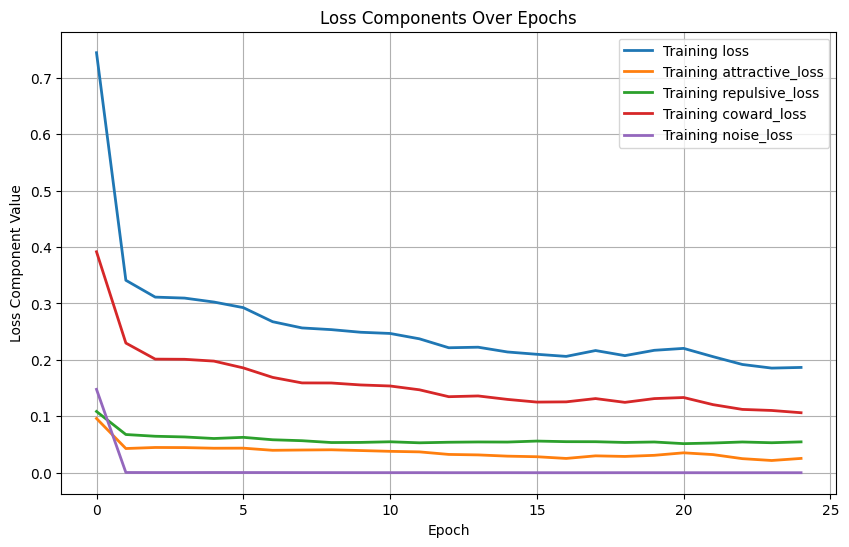

In [50]:
# Define the loss component keys.
loss_components = ['loss','attractive_loss', 'repulsive_loss', 'coward_loss', 'noise_loss']

plt.figure(figsize=(10, 6))

# Plot training loss components.
for comp in loss_components:
    if comp in history.history:
        plt.plot(history.history[comp], label=f"Training {comp}", linewidth=2)

# Plot validation loss components if available.
for comp in loss_components:
    val_comp = 'val_' + comp
    if val_comp in history.history:
        plt.plot(history.history[val_comp], label=f"Validation {comp}", linestyle='--', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss Component Value')
plt.title('Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

We evaluate the model over the entire dataset for each training epoch. This may take a few minutes.

In [36]:
# --------------------------
# Precompute predictions for all epochs.
# --------------------------
predictions = {}
print("Beginning precomputation (this may take a few minutes).")
for epoch in range(1, epochs+1):
    model_path = f'model_epoch_{epoch:02d}.keras'
    print(f"Loading and predicting with {model_path} ...")
    loaded_model = load_model(model_path, custom_objects={'GravNet': GravNet,
                                                          'make_gravnet_model': make_gravnet_model,
                                                          'CustomLoss': CustomLoss,
                                                          'AttractiveLossMetric': AttractiveLossMetric,
                                                          'RepulsiveLossMetric': RepulsiveLossMetric,
                                                          'CowardLossMetric': CowardLossMetric,
                                                          'NoiseLossMetric': NoiseLossMetric})
    predictions[epoch] = loaded_model.predict(X)
print("Precomputation complete.")


Beginning precomputation (this may take a few minutes).
Loading and predicting with model_epoch_01.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Loading and predicting with model_epoch_02.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Loading and predicting with model_epoch_03.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Loading and predicting with model_epoch_04.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Loading and predicting with model_epoch_05.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Loading and predicting with model_epoch_06.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Loading and predicting with model_epoch_07.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Loading and predicting with model_epoch_08.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
Loading and predicting with model_epoch_09.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Loading and predicting with model_epoch_10.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Loading and pr

In the code below, we can inspect the clustering performance for different epochs and events. Also we can tweak the `tD` and `tB` which define the minimum radius of clustering and minimum $\beta$ for a new cluster seed to start, respectively. See the Object Condensation paper for details (https://arxiv.org/abs/2002.03605).

You can see that even for 25 epochs, the model is able to cluster fairly well. I would encourage you to go back and set the `force_same_sector=True` flag so that each event produces at least 2 particles per sector. One of the worries is that the model we have trained is figuring out that each sector likely contains only one particle (this is statistically likely, at least at CLAS12). Testing the model's robustness against simply "sector-finding" the input hits takes many more input events and training epochs.



In [52]:
def update_strip_plots(event, training_epoch, tD, tB, cluster_idx):
    """
    Interactive function to display three linked plots for a given event:
      - Left: Original strip plot on a hexagonal grid.
      - Middle: Latent space from model predictions (β and latent [x,y]) with clustering circles.
      - Right: Original strip plot with the selected cluster highlighted.

    Parameters:
        event (int): Event index.
        training_epoch (int): Which epoch’s predictions to use.
        tD (float): Distance threshold for clustering in latent space.
        tB (float): Minimum β (strip length/confidence) threshold for clustering.
        cluster_idx (int): Index of the cluster to highlight in the right plot.
    """
    # -------------------------
    # Prepare the strip data for the event.
    # -------------------------
    # strip_X shape: [K, 8] (columns: 0,1=x1,y1; 3,4=x2,y2; column 7 is layer)
    # strip_y shape: [K,] with particle IDs (only > 0 are valid)
    X_event_all = strip_X[event]
    y_event_all = strip_y[event].squeeze()

    # Filter out background strips (particle id <= 0)
    mask = y_event_all > 0
    X_event = X_event_all[mask]
    y_event = y_event_all[mask]

    # -------------------------
    # Use model predictions for latent space.
    # We assume predictions[training_epoch] has shape [N, num_points, 3]:
    #   Column 0: β value (confidence or strip length)
    #   Columns 1,2: latent coordinates (x, y)
    # -------------------------
    # Extract predictions for the event and then apply the same mask
    y_pred_event = predictions[training_epoch][event]
    y_pred_event = y_pred_event[mask]
    betas = y_pred_event[..., 0].flatten()      # shape: [num_hits,]
    latent_coords = y_pred_event[..., 1:3]        # shape: [num_hits, 2]

    # -------------------------
    # Assign colors based on unique particle IDs from the original strips.
    # -------------------------
    unique_ids = np.unique(y_event)
    cmap = plt.get_cmap("Set1", 10)
    id_to_color = {pid: cmap(i) for i, pid in enumerate(unique_ids)}
    colors = np.array([id_to_color[pid] for pid in y_event])

    # -------------------------
    # Cluster the latent points using thresholds tD and tB.
    # -------------------------
    num_points = latent_coords.shape[0]
    clustered = np.zeros(num_points, dtype=bool)
    clusters_info = []  # List of dicts with cluster info

    sorted_indices = np.argsort(-betas)  # descending order by β
    for idx in sorted_indices:
        if betas[idx] < tB:
            continue  # Skip if below threshold.
        if clustered[idx]:
            continue  # Already assigned.
        center_x, center_y = latent_coords[idx]
        distances = np.sqrt((latent_coords[:,0] - center_x)**2 + (latent_coords[:,1] - center_y)**2)
        members = np.where((distances <= tD) & (~clustered))[0]
        clustered[members] = True
        clusters_info.append({
            'center_idx': idx,
            'members': members,
            'center_x': center_x,
            'center_y': center_y,
            'color': colors[idx]
        })

    # -------------------------
    # Create a 3-panel figure.
    # -------------------------
    fig, axs = plt.subplots(1, 3, figsize=(12, 4),dpi=150)
    ax_left, ax_middle, ax_right = axs

    # --- Left Panel: Original Strip Plot ---
    for strip, pid in zip(X_event, y_event):
        x1, y1, _, x2, y2, _, _, layer = strip
        color = id_to_color[pid]
        ax_left.plot([x1, x2], [y1, y2], color='black', linewidth=1, alpha=0.3)
        ax_left.plot(x1, y1, marker='o', markersize=8,
                     markerfacecolor=color, markeredgecolor='black', alpha=0.75)
        ax_left.plot(x2, y2, marker='o', markersize=8,
                     markerfacecolor=color, markeredgecolor='black', alpha=0.75)
    # Draw dotted hexagonal grid lines (centered at (0.5, 0.5)).
    center_grid = (0.5, 0.5)
    xlim = ax_left.get_xlim()
    ylim = ax_left.get_ylim()
    r = max(abs(xlim[0]-center_grid[0]), abs(xlim[1]-center_grid[0]),
            abs(ylim[0]-center_grid[1]), abs(ylim[1]-center_grid[1])) * 5
    angles_deg = [90 + i*60 for i in range(6)]
    for angle in angles_deg:
        angle_rad = np.deg2rad(angle)
        x_end = center_grid[0] + r * np.cos(angle_rad)
        y_end = center_grid[1] + r * np.sin(angle_rad)
        ax_left.plot([center_grid[0], x_end], [center_grid[1], y_end],
                     linestyle=':', color='gray')
    ax_left.set_title(f"Original Strip Plot (Event {event})")
    ax_left.set_xlim(0, 1)
    ax_left.set_ylim(0, 1)
    ax_left.set_xlabel("X")
    ax_left.set_ylabel("Y")

    # --- Middle Panel: Latent Space with Clustering ---
    marker_alpha = [max(b, 0.05) for b in betas]
    ax_middle.scatter(latent_coords[:,0], latent_coords[:,1],
                       c=colors, s=50, alpha=marker_alpha, edgecolor='black')
    # Draw a dashed circle for each cluster.
    for cluster in clusters_info:
        circle = plt.Circle((cluster['center_x'], cluster['center_y']), tD,
                            color=cluster['color'], fill=True, hatch="//",
                            linestyle='--', linewidth=2, alpha=0.3)
        ax_middle.add_patch(circle)
    ax_middle.set_title(f"Latent Space (Epoch {training_epoch})")
    ax_middle.set_xlabel("Latent X")
    ax_middle.set_ylabel("Latent Y")
    ax_middle.axis('equal')

    # --- Right Panel: Original Plot with Cluster Highlight ---
    for strip, pid in zip(X_event, y_event):
        x1, y1, _, x2, y2, _, _, layer = strip
        color = id_to_color[pid]
        ax_right.plot([x1, x2], [y1, y2], color='black', linewidth=1, alpha=0.3)
        ax_right.plot(x1, y1, marker='o', markersize=8,
                     markerfacecolor=color, markeredgecolor='black', alpha=0.75)
        ax_right.plot(x2, y2, marker='o', markersize=8,
                     markerfacecolor=color, markeredgecolor='black', alpha=0.75)
    # Highlight the selected cluster if it exists.
    if clusters_info and (cluster_idx < len(clusters_info)):
        selected_cluster = clusters_info[cluster_idx]
        for member in selected_cluster['members']:
            strip = X_event[member]
            x1, y1, _, x2, y2, _, _, layer = strip
            ax_right.plot([x1, x2], [y1, y2], color='red', linewidth=2, alpha=0.8)
    # Draw hexagonal grid lines on the right.
    xlim = ax_right.get_xlim()
    ylim = ax_right.get_ylim()
    r = max(abs(xlim[0]-center_grid[0]), abs(xlim[1]-center_grid[0]),
            abs(ylim[0]-center_grid[1]), abs(ylim[1]-center_grid[1])) * 5
    for angle in angles_deg:
        angle_rad = np.deg2rad(angle)
        x_end = center_grid[0] + r * np.cos(angle_rad)
        y_end = center_grid[1] + r * np.sin(angle_rad)
        ax_right.plot([center_grid[0], x_end], [center_grid[1], y_end],
                      linestyle=':', color='gray')
    ax_right.set_title("Cluster Highlight in Original Strips")
    ax_right.set_xlim(0, 1)
    ax_right.set_ylim(0, 1)
    ax_right.set_xlabel("X")
    ax_right.set_ylabel("Y")

    fig.suptitle(f"Event {event} | Epoch {training_epoch}: tD = {tD}, tB = {tB}", fontsize=16)
    plt.tight_layout()
    plt.show()

# -------------------------
# Create interactive widgets.
# -------------------------
event_slider = widgets.IntSlider(value=0, min=0, max=strip_X.shape[0]-1, step=1, description='Event:')
epoch_slider = widgets.IntSlider(value=1, min=1, max=epochs, step=1, description='Epoch:')
tD_slider = widgets.FloatSlider(value=0.38, min=0.0, max=1, step=0.01, description='tD:')
tB_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1, step=0.01, description='tB:')
cluster_slider = widgets.IntSlider(value=0, min=0, max=10, step=1, description='Cluster:')

interactive_plot = interact(update_strip_plots,
                              event=event_slider,
                              training_epoch=epoch_slider,
                              tD=tD_slider,
                              tB=tB_slider,
                              cluster_idx=cluster_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Event:', max=999), IntSlider(value=1, description='Epoch…

<function __main__.update_strip_plots(event, training_epoch, tD, tB, cluster_idx)>